# ✅ Decisiones de Preprocesamiento basadas en el EDA

## 🧼 Variables a descartar

| Variable          | Justificación                  |
| ----------------- | ------------------------------ |
| `gb_id`           | Es un ID sin valor predictivo. |
| `conference_name` | 89% nulos → no aporta.         |
| `quartile_value`  | 100% nulo → eliminar.          |


## 🧠 Variables textuales
- title, abstract, keywords: juntas tienen mucho potencial.
- Algunas publicaciones no tienen abstract, pero casi todas tienen title y keywords, así que es útil concatenarlas en una nueva columna text.

## 🔠 Variables categóricas

| Variable           | Relevancia           | Acción                                        |
| ------------------ | -------------------- | --------------------------------------------- |
| `language`         | ✅ chi² significativo | Codificar (OneHot o embedding)                |
| `publication_type` | ❌ Introduce ruido    | Eliminar                                      |
| `source`           | ❌ No coinciden       | Eliminar                                      |
| `editorial`        | ✅ pero disperso      | Codificar si se limita a top N más frecuentes |

📌 Tip: para source y editorial, agrupamos los valores menos frecuentes en "other" para reducir dimensionalidad.

## 🔢 Variables numéricas

| Variable                      | Observación                                                     |
| ----------------------------- | --------------------------------------------------------------- |
| `citations`                   | Muy sesgada, aplicar log(1+x) o escalado robusto                |
| `impact_factor`, `percentile` | Informativas, poco correladas entre sí                          |
| `year`                        | Distribución conocida → usar como feature numérico directamente |

## 🎯 Variable objetivo: label

- El 62% tiene solo una etiqueta → empezaremos como problema de clasificación multiclase.
- Más adelante probaremos a ampliarlo a multilabel si es útil.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import joblib
import scipy

# === Cargar dataset ===
df = pd.read_csv("../data/datasets/publications_training_dataset.csv", index_col='gb_id')

Eliminar columnas no útiles

In [2]:
df = df.drop(columns=["conference_name", "quartile_value"])

Eliminar clases con muy pocas muestras

In [3]:
label_counts = df['label'].value_counts()
labels_to_keep = label_counts[label_counts > 3].index
df = df[df['label'].isin(labels_to_keep)].copy()

Rellenar NaNs + construir texto unificado

In [4]:
df['title'] = df['title'].fillna('')
df['keywords'] = df['keywords'].fillna('')
df['text'] = df['title'] + ' ' + df['keywords']

In [5]:
df['jcr_materia_main'] = df['jcr_materias'].fillna('').apply(lambda x: x.split(';')[0] if x else 'unknown')

Limitar categorías más frecuentes

Preprocesamiento numérico: log transform + fillna

In [6]:
df['citations'] = df['citations'].fillna(0)
df['citations_log'] = np.log1p(df['citations'])

In [7]:
for col in ['impact_factor', 'percentile', 'international_collab', 'num_countries', 'num_foreign_affils', 'num_spanish_affils']:
    df[col] = df[col].fillna(0)

In [8]:
for col in ['source', 'editorial', 'publication_type']:
    df[col] = df[col].fillna('')

Selección de columnas

In [9]:
X = df[[
    'text', 'language', 'editorial', 'source', 'publication_type',
    'jcr_materia_main',
    'citations_log', 'impact_factor', 'percentile', 'year',
    'international_collab', 'num_countries', 'num_foreign_affils', 'num_spanish_affils'
]]
y = df['label']

## PIPELINE

In [10]:
from sklearn.decomposition import TruncatedSVD

# === Subpipelines ===

text_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=3000, stop_words='english')),
    ('svd', TruncatedSVD(n_components=800, random_state=42))
])

source_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=100, stop_words='english')),
    ('svd', TruncatedSVD(n_components=20, random_state=42))
])

editorial_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=100, stop_words='english')),
    ('svd', TruncatedSVD(n_components=20, random_state=42))
])

pubtype_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=100, stop_words='english')),
    ('svd', TruncatedSVD(n_components=20, random_state=42))
])

categorical_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numeric_cols = ['citations_log', 'impact_factor', 'percentile', 'year',
                'international_collab', 'num_countries', 'num_foreign_affils', 'num_spanish_affils']

numeric_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

# === ColumnTransformer combinado ===
preprocessor = ColumnTransformer(transformers=[
    ('text', text_pipeline, 'text'),
    ('source', source_pipeline, 'source'),
    ('editorial', editorial_pipeline, 'editorial'),
    ('pubtype', pubtype_pipeline, 'publication_type'),
    ('cat', categorical_pipeline, ['language', 'jcr_materia_main']),
    ('num', numeric_pipeline, numeric_cols)
])


Preprocesamos y guardamos el resultado

In [11]:
X_processed = preprocessor.fit_transform(X)

# Si es matriz dispersa (TF-IDF), conviértela a densa primero (solo si no es muy grande)
if scipy.sparse.issparse(X_processed):
    X_processed = X_processed.toarray()

In [12]:
# Guarda el preprocessor entrenado
import joblib
joblib.dump(preprocessor, "../data/datasets/preprocessor.joblib")

['../data/datasets/preprocessor.joblib']

In [13]:
# Guardar como DataFrame
X_df = pd.DataFrame(X_processed, index=X.index)
X_df.to_csv("X_ready.csv", index=True)
y.to_csv("y_ready.csv", index=True)

print("✅ Dataset preprocesado guardado como 'X_ready.csv' y 'y_ready.csv'")

print(X_df.shape)
print(y.shape)

✅ Dataset preprocesado guardado como 'X_ready.csv' y 'y_ready.csv'
(2057, 919)
(2057,)


Prueba de varianza explicada acumulada

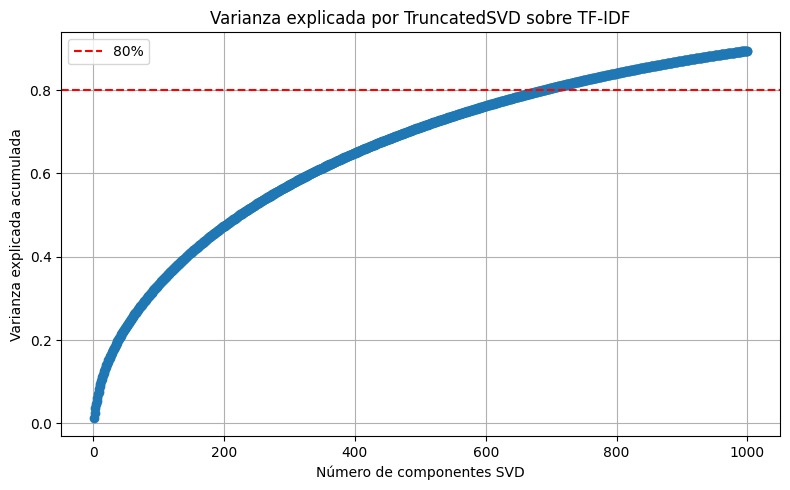

In [14]:
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

df = pd.read_csv("../data/datasets/publications_training_dataset.csv")
df['text'] = (
    df['title'].fillna('') + ' ' +
    df['keywords'].fillna('')
)

# === TF-IDF vectorizer ===
tfidf = TfidfVectorizer(max_features=3000, stop_words='english')
X_tfidf = tfidf.fit_transform(df['text'])

# === SVD ===
n_components = 1000
svd = TruncatedSVD(n_components=n_components, random_state=42)
X_svd = svd.fit_transform(X_tfidf)

# === Varianza explicada acumulada ===
explained_variance = svd.explained_variance_ratio_.cumsum()

plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, n_components+1), explained_variance, marker='o')
plt.xlabel("Número de componentes SVD")
plt.ylabel("Varianza explicada acumulada")
plt.title("Varianza explicada por TruncatedSVD sobre TF-IDF")
plt.grid(True)
plt.tight_layout()
plt.axhline(y=0.80, color='r', linestyle='--', label='80%')
plt.legend()
plt.show()

## Aplicamos el mismo preprocesamiento sobre el dataset a predecir

In [15]:
# === Cargar dataset ===
df = pd.read_csv("../data/datasets/publications_to_predict_dataset.csv", index_col='gb_id')

df = df.drop(columns=["conference_name", "quartile_value"])

df['title'] = df['title'].fillna('')
df['keywords'] = df['keywords'].fillna('')
df['text'] = df['title'] + ' ' + df['keywords']

df['jcr_materia_main'] = df['jcr_materias'].fillna('').apply(lambda x: x.split(';')[0] if x else 'unknown')

df['citations'] = df['citations'].fillna(0)
df['citations_log'] = np.log1p(df['citations'])

for col in ['impact_factor', 'percentile', 'international_collab', 'num_countries', 'num_foreign_affils', 'num_spanish_affils']:
    df[col] = df[col].fillna(0)

for col in ['source', 'editorial', 'publication_type']:
    df[col] = df[col].fillna('')
    
X = df[[
    'text', 'language', 'editorial', 'source', 'publication_type',
    'jcr_materia_main',
    'citations_log', 'impact_factor', 'percentile', 'year',
    'international_collab', 'num_countries', 'num_foreign_affils', 'num_spanish_affils'
]]

preprocessor = joblib.load("../data/datasets/preprocessor.joblib")  # ✅ carga el original
X_processed = preprocessor.transform(X)

# Si es matriz dispersa (TF-IDF), conviértela a densa primero (solo si no es muy grande)
if scipy.sparse.issparse(X_processed):
    X_processed = X_processed.toarray()

# Guardar como DataFrame
X_df = pd.DataFrame(X_processed, index=X.index)
X_df.to_csv("X_to_predict_ready.csv", index=True)

print("✅ Dataset preprocesado guardado como 'X_ready.csv' y 'y_ready.csv'")

print(X_df.shape)

✅ Dataset preprocesado guardado como 'X_ready.csv' y 'y_ready.csv'
(1119, 919)
